# Training a regression model using TensorFlow
> This is a basic tutorial for training a regression model using Tensorflow. It covers:

1- Regression to approximate Sine function using Multilayer Perceptron (MLP)

2- Conversion of the Tensorflow model to Tensorflow Lite (quantization)

Inspired from:
https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world/



In [23]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

plt.rcParams['figure.figsize'] = (32, 20)
plt.rcParams['text.usetex'] = True
plt.rc('font', size=15)
plt.style.use('classic')


### Hello world
In this example, our ML regression hypothesis will approximate the sine function.

$$ \tilde{h}(x) = \sin(x) $$



In [2]:
# Seed the RNG to get the same random numbers everytime
np.random.seed(1) # numpy seed
tf.random.set_seed(1) # tensorflow seed

In [3]:
print('Numpy: {}'.format(np.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Numpy: 1.26.4
Tensorflow: 2.10.0


Generate artificial training data through known function i.e. sine

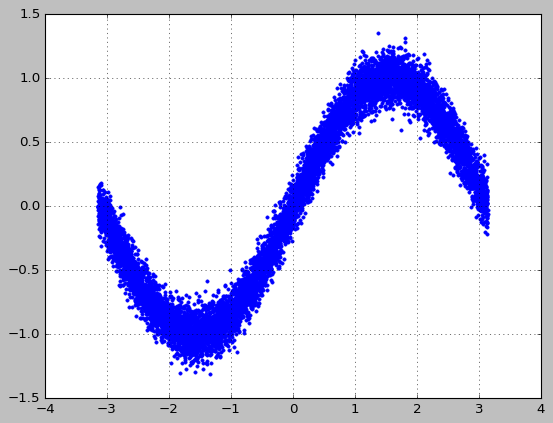

In [4]:
# Generate uniformly distributed RVs in the range [0 2*pi].
#X = np.random.uniform(low=0, high=2*math.pi, size=10000).astype(np.float32)

# Generate uniformly distributed RVs in the range [-pi pi]
#This dataset give a better output! Maybe because data is centered around zero?
X = np.random.uniform(low=-math.pi, high=math.pi, size=10000).astype(np.float32)

# Shuffle to break order
np.random.shuffle(X)

# Calculate the labels
y = np.sin(X).astype(np.float32)

# Add a little noise to make it realistic
y += 0.1 * np.random.randn(*y.shape)

# Plot our data
plt.plot(X, y, 'b.')
plt.grid()
plt.show()


Split the data as follows:
    
- Train data: 60%
- Validation data: 20%
- Test data: 20%

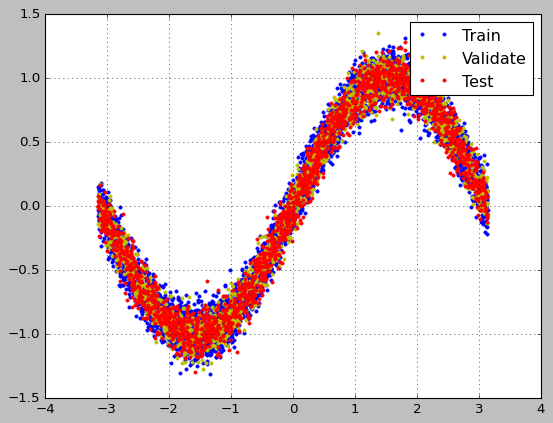

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Plot using different colors:
plt.plot(X_train, y_train, 'b.', label="Train")
plt.plot(X_val, y_val, 'y.', label="Validate")
plt.plot(X_test, y_test, 'r.', label="Test")
plt.legend()
plt.grid()
plt.show()

Our regression model will have three layers: input, hidden and output. The hidden layer has 16 neurons with Relu activation function. To implement this, we use the sequential model in tensorflow-keras.
We will use Adam optimizer with a learning rate of 1.5. Mean Squared Error (MSE) will be the loss and Mean Absolute Error (MAE) will also be plotted to see the training progress.

In [58]:
model1 = tf.keras.Sequential(name='sine_mlp')
model1.add(tf.keras.layers.Dense(4, activation='relu', input_shape=(1, )))
# model1.add(tf.keras.layers.Dense(16, activation='sigmoid', input_shape=(1, )))
model1.add(tf.keras.layers.Dense(1))
#No activation layer applied at the output i.e. linear

model1.summary()

Model: "sine_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 4)                 8         
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [59]:
#model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])
optimizer = tf.keras.optimizers.Adam(lr=0.010)
model1.compile(optimizer=optimizer, loss='mse', metrics=['accuracy', 'mae'])

Let's train it with a batch size of 15 for 50 epochs.

In [60]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=600, validation_data=(X_val, y_val), verbose=True)

Epoch 1/100
10/10 [==============================] - 0s 17ms/step - loss: 0.4164 - accuracy: 0.0000e+00 - mae: 0.5565 - val_loss: 0.3180 - val_accuracy: 0.0000e+00 - val_mae: 0.4854
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.2656 - accuracy: 0.0000e+00 - mae: 0.4445 - val_loss: 0.2158 - val_accuracy: 0.0000e+00 - val_mae: 0.4011
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1891 - accuracy: 0.0000e+00 - mae: 0.3751 - val_loss: 0.1608 - val_accuracy: 0.0000e+00 - val_mae: 0.3483
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1521 - accuracy: 0.0000e+00 - mae: 0.3344 - val_loss: 0.1404 - val_accuracy: 0.0000e+00 - val_mae: 0.3151
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1381 - accuracy: 0.0000e+00 - mae: 0.3120 - val_loss: 0.1284 - val_accuracy: 0.0000e+00 - val_mae: 0.2983
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1242 - accuracy: 0.

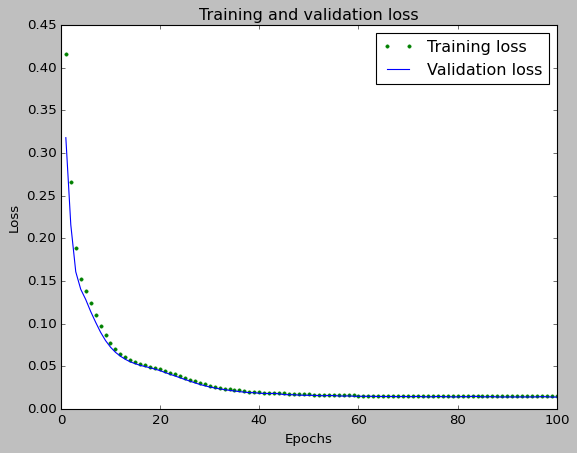

In [61]:
# Plot the training and validation losses.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


63/63 [==============================] - 0s 975us/step


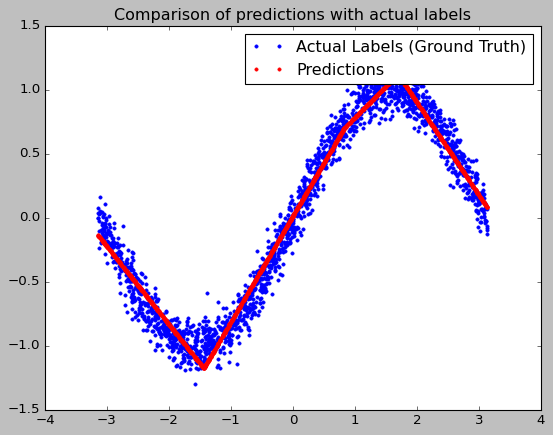

In [62]:
# Evaluate the model on Test set
loss = model1.evaluate(X_test, y_test)
predictions = model1.predict(X_test)
# print(predictions)

# Visualize the predictions against labels
plt.clf()
plt.title('Comparison of predictions with actual labels')
plt.plot(X_test, y_test, 'b.', label='Actual Labels (Ground Truth)')
plt.plot(X_test, predictions, 'r.', label='Predictions')
plt.legend()
plt.show()

Let's try a model with more hidden layers (deep) but with fewer neurons per layer

In [11]:
model2 = tf.keras.Sequential(name='sine_mlp_deep')

# Input to the first layer is a scalar which feeds the next hidden layer with 4 neurons
model2.add(tf.keras.layers.Dense(12, activation='relu', input_shape=(1,)))

# The second layer has 4 neurons and will learn more complex features than one hidden layer alone
model2.add(tf.keras.layers.Dense(4, activation='relu'))

# Final layer outputs a scalar
model2.add(tf.keras.layers.Dense(1))

# Compile the model and set appropriate training parameters
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
optimizer = tf.keras.optimizers.Adam(lr=0.1)
model2.compile(optimizer=optimizer, loss='mse', metrics=['accuracy', 'mae'])

model2.summary()

Model: "sine_mlp_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                24        
                                                                 
 dense_3 (Dense)             (None, 4)                 52        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model2.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_val, y_val), verbose=True)

Epoch 1/50
94/94 [==============================] - 1s 7ms/step - loss: 0.0792 - accuracy: 0.0000e+00 - mae: 0.1996 - val_loss: 0.0411 - val_accuracy: 0.0000e+00 - val_mae: 0.1461
Epoch 2/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0456 - accuracy: 0.0000e+00 - mae: 0.1575 - val_loss: 0.0432 - val_accuracy: 0.0000e+00 - val_mae: 0.1538
Epoch 3/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0443 - accuracy: 0.0000e+00 - mae: 0.1527 - val_loss: 0.0408 - val_accuracy: 0.0000e+00 - val_mae: 0.1434
Epoch 4/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0439 - accuracy: 0.0000e+00 - mae: 0.1518 - val_loss: 0.0439 - val_accuracy: 0.0000e+00 - val_mae: 0.1513
Epoch 5/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.0000e+00 - mae: 0.1541 - val_loss: 0.0444 - val_accuracy: 0.0000e+00 - val_mae: 0.1432
Epoch 6/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.0000e+0

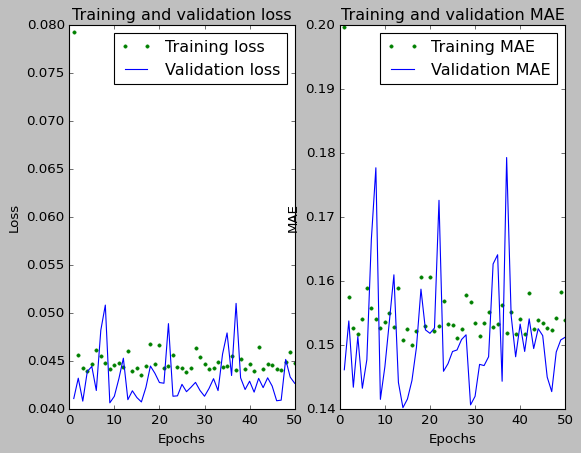

In [13]:
# Plot the training and validation losses.
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'g.', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#plt.tight_layout()

63/63 [==============================] - 0s 838us/step


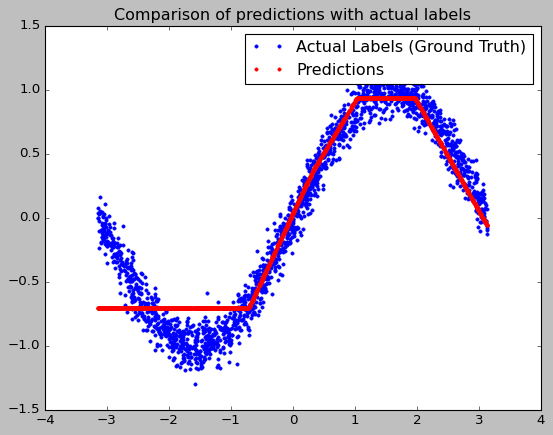

In [14]:
# Evaluate the model on Test set
loss = model2.evaluate(X_test, y_test)
predictions = model2.predict(X_test)

# Visualize the predictions against labels
plt.clf()
plt.title('Comparison of predictions with actual labels')
plt.plot(X_test, y_test, 'b.', label='Actual Labels (Ground Truth)')
plt.plot(X_test, predictions, 'r.', label='Predictions')
plt.legend()
plt.show()


The deep model with two hidden layers (33 parameters) seems to give similar performance as the one with one hidden layer (49 parameters).

In [15]:
import os
MODEL_DIR = './models/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [16]:
model2.save('/content/gdrive/MyDrive/' + 'tfMdl')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/tfMdl\assets


In [17]:

model2.save('/content/gdrive/MyDrive/' + 'tfMdl')

# Convert the model to the TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
model_tflite = converter.convert()

# Save on disk
open(MODEL_DIR + 'model2.tflite', "wb").write(model_tflite)

# Quantize the model
def representative_dataset():
    for i in range(500):
        yield([X_train[i].reshape(1, 1)])
# Optimization level.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Perform int8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#Setting the following input/output type requires the input/output to be quantized manually in the inference code.
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
# Representative dataset for
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_DIR + 'model2_q.tflite', "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/tfMdl\assets
INFO:tensorflow:Assets written to: C:\Users\mbilal\AppData\Local\Temp\tmpnxfey2ud\assets
INFO:tensorflow:Assets written to: C:\Users\mbilal\AppData\Local\Temp\tmpwoa5t3_u\assets


INFO:tensorflow:Assets written to: C:\Users\mbilal\AppData\Local\Temp\tmpwoa5t3_u\assets
c:\Users\mbilal\.conda\envs\tf-gpu\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


2784

In [18]:
model_size = os.path.getsize(MODEL_DIR + 'model2.tflite')
print("Original model size is %d bytes" % model_size)
model_size_q = os.path.getsize(MODEL_DIR + 'model2_q.tflite')
print("Quantized model size is %d bytes" % model_size_q)
difference = model_size - model_size_q
print("You saved %d bytes!" % difference)

Original model size is 2264 bytes
Quantized model size is 2784 bytes
You saved -520 bytes!


C:\Users\mbilal\AppData\Local\Temp\ipykernel_14204\827773695.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model_predictions[i] = model_output()[0]
C:\Users\mbilal\AppData\Local\Temp\ipykernel_14204\827773695.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model_q_predictions[i] = model_q_output()[0]


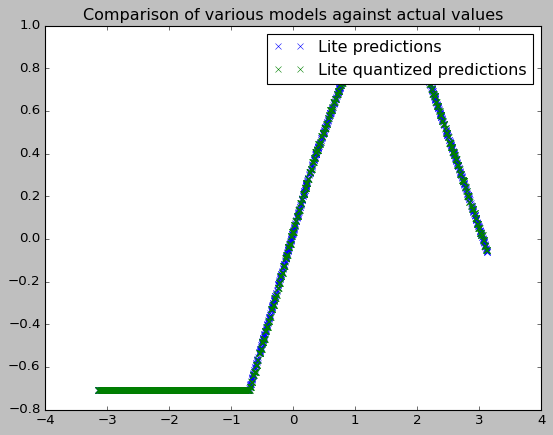

In [19]:
# Instantiate an interpreter for each model
model = tf.lite.Interpreter(MODEL_DIR + 'model2.tflite')
model_q = tf.lite.Interpreter(MODEL_DIR + 'model2_q.tflite')

# Allocate memory for each model
model.allocate_tensors()
model_q.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
model_input = model.tensor(model.get_input_details()[0]["index"])
model_output = model.tensor(model.get_output_details()[0]["index"])
model_q_input = model_q.tensor(model_q.get_input_details()[0]["index"])
model_q_output = model_q.tensor(model_q.get_output_details()[0]["index"])

# Create arrays to store the results
model_predictions = np.empty(X_test.size)
model_q_predictions = np.empty(X_test.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(X_test.size):
    model_input().fill(X_test[i])
    model.invoke()
    model_predictions[i] = model_output()[0]

    model_q_input().fill(X_test[i])
    model_q.invoke()
    model_q_predictions[i] = model_q_output()[0]

#error = model_predictions - model_q_predictions
# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
#plt.plot(X_test, y_test, 'bo', label='Actual values', alpha=0.4)
#plt.plot(X_test, predictions, 'ro', label='Original predictions')
plt.plot(X_test, model_predictions, 'bx', label='Lite predictions')
plt.plot(X_test, model_q_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

In [20]:

tf.lite.experimental.Analyzer.analyze(model_content=model_tflite)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #7 as output.

Subgraph#0 main(T#0) -> [T#11]
  Op#0 QUANTIZE(T#0) -> [T#7]
  Op#1 FULLY_CONNECTED(T#7, T#6[], T#5[-3079, -84, 402, -6156, -5675, ...]) -> [T#8]
  Op#2 FULLY_CONNECTED(T#8, T#4[], T#3[-2307, -1510, 10452, -2588]) -> [T#9]
  Op#3 FULLY_CONNECTED(T#9, T#2[], T#1[-13986]) -> [T#10]
  Op#4 DEQUANTIZE(T#10) -> [T#11]

Tensors of Subgraph#0
  T#0(serving_default_dense_2_input:0) shape_signature:[-1, 1], type:FLOAT32
  T#1(sine_mlp_deep/dense_4/BiasAdd/ReadVariableOp) shape:[1], type:INT32 RO 4 bytes, data:[-13986]
  T#2(sine_mlp_deep/dense_4/MatMul) shape:[1, 4], type:INT8 RO 4 bytes, data:[]
  T#3(sine_mlp_deep/dense_3/BiasAdd/ReadVariableOp) shape:[4], type:INT32 RO 16 bytes, data:[-2307, -1510, 10452, -2588]
  T#4(sine_mlp_deep/dense_3/MatMul) shape:

In [21]:
!xxd -i {MODEL_DIR + 'model2_q.tflite'} > {MODEL_DIR + 'model_q.cc'}
!xxd -i {MODEL_DIR + 'model2.tflite'} > {MODEL_DIR + 'model.cc'}

'xxd' is not recognized as an internal or external command,
operable program or batch file.
'xxd' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
!cat {MODEL_DIR + 'model.cc'}

'cat' is not recognized as an internal or external command,
operable program or batch file.
